Upload Kaggle Api Token

In [ ]:
from google.colab import files
files.upload()

In [2]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset
!unzip /content/coronahack-chest-xraydataset.zip
!rm /content/coronahack-chest-xraydataset.zip

!kaggle datasets download -d alexkort/xray-covid19
!mkdir xray-covid
!unzip /content/xray-covid19.zip -d xray-covid
!rm /content/xray-covid19.zip

!kaggle datasets download -d haicute/covid19duyhai
!unzip /content/covid19duyhai.zip
!rm /content/covid19duyhai.zip

Streaming output truncated to the last 5000 lines.
  inflating: data_v1/data/train/pneumonia/3fbd4620-cd61-4c5d-a067-aa8025df7430.png  
  inflating: data_v1/data/train/pneumonia/3fbd74df-08fb-4145-abdc-5e27828b3d30.png  
  inflating: data_v1/data/train/pneumonia/3fc09255-ac70-4e8b-8507-efde01c9fd45.png  
  inflating: data_v1/data/train/pneumonia/3fc199bf-56c1-48fe-a00a-7592e3c00e3c.png  
  inflating: data_v1/data/train/pneumonia/3fc3e7fb-1fff-4ad0-9900-8874ada57d05.png  
  inflating: data_v1/data/train/pneumonia/3fcd4b0a-c575-40a8-95ce-34eab7025d62.png  
  inflating: data_v1/data/train/pneumonia/3fd78890-11cf-4bb2-88ac-0a8e7fc54c61.png  
  inflating: data_v1/data/train/pneumonia/3fdcd01b-1029-40c9-be8a-a72876d0323b.png  
  inflating: data_v1/data/train/pneumonia/3ff0bd8f-7257-4ba9-a4ae-ae0c9f9138d7.png  
  inflating: data_v1/data/train/pneumonia/3ff30575-fa0f-4e5c-bba6-651f4ea724af.png  
  inflating: data_v1/data/train/pneumonia/3ff3fc6e-bef0-4d90-a4a5-0eb40c1f7710.png  
  inflating: d

Import libraries

In [1]:
import pandas as pd
import tensorflow as tf
import cv2
from tensorflow import keras
from google.colab.patches import cv2_imshow
import numpy as np
import os

Read Datasets

In [4]:
""" ّFirst Dataset """
summary = pd.read_csv('Chest_xray_Corona_dataset_Summary.csv')
summary

,Unnamed: 0,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,0,Normal,NaN,NaN,1576
1,1,Pnemonia,Stress-Smoking,ARDS,2
2,2,Pnemonia,Virus,NaN,1493
3,3,Pnemonia,Virus,COVID-19,58
4,4,Pnemonia,Virus,SARS,4
5,5,Pnemonia,bacteria,NaN,2772
6,6,Pnemonia,bacteria,Streptococcus,5


In [2]:
data = pd.read_csv('Chest_xray_Corona_Metadata.csv')
data = pd.DataFrame(data)
data.drop(labels=['Unnamed: 0','Label_2_Virus_category','Label'],axis = 1,inplace=True)
data = data.fillna(0)
data['Label_1_Virus_category'].loc[(data['Label_1_Virus_category'] == 'Virus')] = 2
data['Label_1_Virus_category'].loc[(data['Label_1_Virus_category'] == 'bacteria')] = 1
data = data.fillna(0)
data.drop(data.loc[data['Label_1_Virus_category'] == 'Stress-Smoking'].index,inplace = True)

data_tmp = data
data.loc[data['Dataset_type'] == "TRAIN","X_ray_image_name"] = "/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/" + data_tmp.loc[data_tmp['Dataset_type'] == "TRAIN","X_ray_image_name"]
data.loc[data['Dataset_type'] == "TEST","X_ray_image_name"] = "/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/" + data_tmp.loc[data_tmp['Dataset_type'] == "TEST","X_ray_image_name"]
data

,X_ray_image_name,Dataset_type,Label_1_Virus_category
0,/content/Coronahack-Chest-XRay-Dataset/Coronah...,TRAIN,0
1,/content/Coronahack-Chest-XRay-Dataset/Coronah...,TRAIN,0
2,/content/Coronahack-Chest-XRay-Dataset/Coronah...,TRAIN,0
3,/content/Coronahack-Chest-XRay-Dataset/Coronah...,TRAIN,0
4,/content/Coronahack-Chest-XRay-Dataset/Coronah...,TRAIN,0
...,...,...,...
5905,/content/Coronahack-Chest-XRay-Dataset/Coronah...,TEST,2
5906,/content/Coronahack-Chest-XRay-Dataset/Coronah...,TEST,2
5907,/content/Coronahack-Chest-XRay-Dataset/Coronah...,TEST,2
5908,/content/Coronahack-Chest-XRay-Dataset/Coronah...,TEST,2


In [3]:
""" Second Dataset """
train_1 = os.listdir('/content/xray-covid/train/normal')
for i in range(len(train_1)):
  train_1[i] = '/content/xray-covid/train/normal/' + train_1[i]

train_2 = os.listdir('/content/xray-covid/train/pneumonia')
for i in range(len(train_2)):
  train_2[i] = '/content/xray-covid/train/pneumonia/' + train_2[i]

train_3 = os.listdir('/content/xray-covid/train/COVID-19')
for i in range(len(train_3)):
  train_3[i] = '/content/xray-covid/train/COVID-19/' + train_3[i]

train_1_df = pd.DataFrame({'X_ray_image_name':train_1,'Dataset_type':['TRAIN']*len(train_1),'Label_1_Virus_category':[0]*len(train_1)})
train_2_df = pd.DataFrame({'X_ray_image_name':train_2,'Dataset_type':['TRAIN']*len(train_2),'Label_1_Virus_category':[1]*len(train_2)})
train_3_df = pd.DataFrame({'X_ray_image_name':train_3,'Dataset_type':['TRAIN']*len(train_3),'Label_1_Virus_category':[3]*len(train_3)})

data = data.append(train_1_df, ignore_index = True)
data = data.append(train_2_df, ignore_index = True)
data = data.append(train_3_df, ignore_index = True)

test_1 = os.listdir('/content/xray-covid/test/normal')
for i in range(len(test_1)):
  test_1[i] = '/content/xray-covid/test/normal/' + test_1[i]

test_2 = os.listdir('/content/xray-covid/test/pneumonia')
for i in range(len(test_2)):
  test_2[i] = '/content/xray-covid/test/pneumonia/' + test_2[i]

test_3 = os.listdir('/content/xray-covid/test/COVID-19')
for i in range(len(test_3)):
  test_3[i] = '/content/xray-covid/test/COVID-19/' + test_3[i]

test_1_df = pd.DataFrame({'X_ray_image_name':test_1,'Dataset_type':['TEST']*len(test_1),'Label_1_Virus_category':[0]*len(test_1)})
test_2_df = pd.DataFrame({'X_ray_image_name':test_2,'Dataset_type':['TEST']*len(test_2),'Label_1_Virus_category':[1]*len(test_2)})
test_3_df = pd.DataFrame({'X_ray_image_name':test_3,'Dataset_type':['TEST']*len(test_3),'Label_1_Virus_category':[3]*len(test_3)})

data = data.append(test_1_df, ignore_index = True)
data = data.append(test_2_df, ignore_index = True)
data = data.append(test_3_df, ignore_index = True)
data

,X_ray_image_name,Dataset_type,Label_1_Virus_category
0,/content/Coronahack-Chest-XRay-Dataset/Coronah...,TRAIN,0
1,/content/Coronahack-Chest-XRay-Dataset/Coronah...,TRAIN,0
2,/content/Coronahack-Chest-XRay-Dataset/Coronah...,TRAIN,0
3,/content/Coronahack-Chest-XRay-Dataset/Coronah...,TRAIN,0
4,/content/Coronahack-Chest-XRay-Dataset/Coronah...,TRAIN,0
...,...,...,...
20100,/content/xray-covid/test/COVID-19/covid-19-pne...,TEST,3
20101,/content/xray-covid/test/COVID-19/CR.1.2.840.1...,TEST,3
20102,/content/xray-covid/test/COVID-19/6C94A287-C05...,TEST,3
20103,/content/xray-covid/test/COVID-19/COVID-19(70)...,TEST,3


In [4]:
""" Third Dataset """
train_1 = os.listdir('/content/data_v1/data/train/normal')
for i in range(len(train_1)):
  train_1[i] = '/content/data_v1/data/train/normal/' + train_1[i]

train_2 = os.listdir('/content/data_v1/data/train/pneumonia')
for i in range(len(train_2)):
  train_2[i] = '/content/data_v1/data/train/pneumonia/' + train_2[i]

train_3 = os.listdir('/content/data_v1/data/train/COVID-19')
for i in range(len(train_3)):
  train_3[i] = '/content/data_v1/data/train/COVID-19/' + train_3[i]

train_1_df = pd.DataFrame({'X_ray_image_name':train_1,'Dataset_type':['TRAIN']*len(train_1),'Label_1_Virus_category':[0]*len(train_1)})
train_2_df = pd.DataFrame({'X_ray_image_name':train_2,'Dataset_type':['TRAIN']*len(train_2),'Label_1_Virus_category':[1]*len(train_2)})
train_3_df = pd.DataFrame({'X_ray_image_name':train_3,'Dataset_type':['TRAIN']*len(train_3),'Label_1_Virus_category':[3]*len(train_3)})

data = data.append(train_1_df, ignore_index = True)
data = data.append(train_2_df, ignore_index = True)
data = data.append(train_3_df, ignore_index = True)

test_1 = os.listdir('/content/data_v1/data/test/normal')
for i in range(len(test_1)):
  test_1[i] = '/content/data_v1/data/test/normal/' + test_1[i]

test_2 = os.listdir('/content/data_v1/data/test/pneumonia')
for i in range(len(test_2)):
  test_2[i] = '/content/data_v1/data/test/pneumonia/' + test_2[i]

test_3 = os.listdir('/content/data_v1/data/test/COVID-19')
for i in range(len(test_3)):
  test_3[i] = '/content/data_v1/data/test/COVID-19/' + test_3[i]

test_1_df = pd.DataFrame({'X_ray_image_name':test_1,'Dataset_type':['TEST']*len(test_1),'Label_1_Virus_category':[0]*len(test_1)})
test_2_df = pd.DataFrame({'X_ray_image_name':test_2,'Dataset_type':['TEST']*len(test_2),'Label_1_Virus_category':[1]*len(test_2)})
test_3_df = pd.DataFrame({'X_ray_image_name':test_3,'Dataset_type':['TEST']*len(test_3),'Label_1_Virus_category':[3]*len(test_3)})

data = data.append(test_1_df, ignore_index = True)
data = data.append(test_2_df, ignore_index = True)
data = data.append(test_3_df, ignore_index = True)
data

,X_ray_image_name,Dataset_type,Label_1_Virus_category
0,/content/Coronahack-Chest-XRay-Dataset/Coronah...,TRAIN,0
1,/content/Coronahack-Chest-XRay-Dataset/Coronah...,TRAIN,0
2,/content/Coronahack-Chest-XRay-Dataset/Coronah...,TRAIN,0
3,/content/Coronahack-Chest-XRay-Dataset/Coronah...,TRAIN,0
4,/content/Coronahack-Chest-XRay-Dataset/Coronah...,TRAIN,0
...,...,...,...
33701,/content/data_v1/data/test/COVID-19/F4341CE7-7...,TEST,3
33702,/content/data_v1/data/test/COVID-19/covid-19-r...,TEST,3
33703,/content/data_v1/data/test/COVID-19/RX-torace-...,TEST,3
33704,/content/data_v1/data/test/COVID-19/covid-19-p...,TEST,3


In [5]:
train_input = data[data.Dataset_type == 'TRAIN']['X_ray_image_name'].values
train_label = data[data.Dataset_type == 'TRAIN']['Label_1_Virus_category'].values
train_label = tf.convert_to_tensor(train_label,dtype=tf.int64)

print("Train samples : ",len(train_input))

test_input = data[data.Dataset_type == 'TEST']['X_ray_image_name'].values
test_label = data[data.Dataset_type == 'TEST']['Label_1_Virus_category'].values
test_label = tf.convert_to_tensor(test_label,dtype=tf.int64)

print("Test samples : ",len(test_input))

Train samples :  31273
Test samples :  2433


Preparing dataset


In [8]:
def proccess_image(inputs):
  img = cv2.imread(bytes.decode(inputs.numpy()))
  img = cv2.resize(img,(300,300))
  return img 

def get_image(inputs, outputs):
    img = tf.py_function(proccess_image, inp=[inputs], Tout=tf.int64)
    if(outputs == 0):
      outputs = [0,0,1]
    elif(outputs == 1):
      outputs = [0,1,0]
    else :
      outputs = [1,0,0]
    return img , outputs

import random 
def augment_data(inputs,outputs):
  r = random. randint(0,4)
  if r == 0:
    data_augmentation = tf.keras.Sequential([
      keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
      keras.layers.experimental.preprocessing.RandomRotation(0.2)
      ])
    return data_augmentation(inputs),outputs
  else :
    return inputs , outputs


In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
X1 = X2 = X3 =  AUTOTUNE 

train_dataset = tf.data.Dataset.from_tensor_slices((train_input,train_label))
train_dataset = train_dataset.shuffle(len(train_input))
train_dataset = train_dataset.map(get_image,num_parallel_calls=X1)
train_dataset = train_dataset.map(augment_data,num_parallel_calls=X3)
train_dataset = train_dataset.batch(batch_size=16).repeat()
train_dataset = train_dataset.prefetch(buffer_size=X2)

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
Y1 = Y2 =  AUTOTUNE 

test_dataset = tf.data.Dataset.from_tensor_slices((test_input,test_label))
test_dataset = test_dataset.shuffle(len(test_input))
test_dataset = test_dataset.map(get_image,num_parallel_calls=X1)
test_dataset = test_dataset.batch(batch_size=16)
test_dataset = test_dataset.prefetch(buffer_size=X2)

Building Model

In [20]:
base_model = keras.applications.EfficientNetB3(include_top= False,input_shape=(300, 300, 3))

for layer in base_model.layers:
    layer.trainable = False

cnn1 = keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer='l2')(base_model.output)
batch_1 = keras.layers.BatchNormalization(axis =1)(cnn1)

cnn2 = keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer='l2')(batch_1)
batch_2 = keras.layers.BatchNormalization(axis =1)(cnn2)

dropout_1 = keras.layers.Dropout(0.2)(batch_2)

flatten = keras.layers.Flatten()(dropout_1)

dense_1 = keras.layers.Dense(128,activation = 'relu')(flatten)
dropout_3 = keras.layers.Dropout(0.2)(dense_1)
dense_2 = keras.layers.Dense(64,activation='relu')(dropout_3)
dense_3 = keras.layers.Dense(3,activation = 'softmax')(dense_2)

model = keras.Model(base_model.input,dense_3)
  
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics='acc') 


Training and Fine tunning

In [23]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model_test_1/', monitor='val_loss',mode='min',verbose=1, save_best_only=True)
history = model.fit(train_dataset,steps_per_epoch=200,epochs = 10,validation_data=test_dataset,callbacks=[checkpoint_callback])

Epoch 1/10
200/200 [==============================] - ETA: 0s - loss: 1.6081 - acc: 0.7775
Epoch 00001: val_loss improved from inf to 1.02453, saving model to model_test_1/
INFO:tensorflow:Assets written to: model_test_1/assets
200/200 [==============================] - 144s 721ms/step - loss: 1.6081 - acc: 0.7775 - val_loss: 1.0245 - val_acc: 0.8187
Epoch 2/10
200/200 [==============================] - ETA: 0s - loss: 0.8448 - acc: 0.8291
Epoch 00002: val_loss improved from 1.02453 to 0.76389, saving model to model_test_1/
INFO:tensorflow:Assets written to: model_test_1/assets
200/200 [==============================] - 140s 702ms/step - loss: 0.8448 - acc: 0.8291 - val_loss: 0.7639 - val_acc: 0.8130
Epoch 3/10
200/200 [==============================] - ETA: 0s - loss: 0.7228 - acc: 0.8128
Epoch 00003: val_loss improved from 0.76389 to 0.71892, saving model to model_test_1/
INFO:tensorflow:Assets written to: model_test_1/assets
200/200 [==============================] - 143s 713ms/step

In [24]:
model = tf.keras.models.load_model('/content/model_test_1')
model.evaluate(test_dataset)

153/153 [==============================] - 38s 251ms/step - loss: 0.5780 - acc: 0.8274


[0.5780133008956909, 0.8273736238479614]

In [25]:
for layer in model.layers :
  layer.trainable = True

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model_test_2/', monitor='val_loss',mode='min',verbose=1, save_best_only=True)
history_2 = model.fit(train_dataset,initial_epoch=10,steps_per_epoch=200,epochs = 30,validation_data=test_dataset,callbacks=[checkpoint_callback])

Epoch 11/30
200/200 [==============================] - ETA: 0s - loss: 0.5937 - acc: 0.8069
Epoch 00011: val_loss improved from inf to 0.55881, saving model to model_test_2/
INFO:tensorflow:Assets written to: model_test_2/assets
200/200 [==============================] - 314s 2s/step - loss: 0.5937 - acc: 0.8069 - val_loss: 0.5588 - val_acc: 0.7941
Epoch 12/30
200/200 [==============================] - ETA: 0s - loss: 0.4611 - acc: 0.8481
Epoch 00012: val_loss did not improve from 0.55881
200/200 [==============================] - 258s 1s/step - loss: 0.4611 - acc: 0.8481 - val_loss: 0.6941 - val_acc: 0.7739
Epoch 13/30
200/200 [==============================] - ETA: 0s - loss: 0.3753 - acc: 0.8769
Epoch 00013: val_loss did not improve from 0.55881
200/200 [==============================] - 257s 1s/step - loss: 0.3753 - acc: 0.8769 - val_loss: 0.5613 - val_acc: 0.8233
Epoch 14/30
200/200 [==============================] - ETA: 0s - loss: 0.4370 - acc: 0.8491
Epoch 00014: val_loss did n

Checking the results

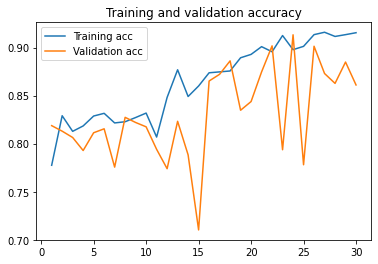

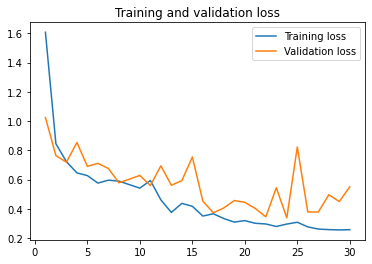

In [26]:
import matplotlib.pyplot as plt

acc = history.history['acc'] + history_2.history['acc']
val_acc = history.history['val_acc'] + history_2.history['val_acc']
loss = history.history['loss'] + history_2.history['loss']
val_loss = history.history['val_loss'] + history_2.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc,  label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
model = tf.keras.models.load_model('/content/model_test_2')
model.evaluate(test_dataset)

153/153 [==============================] - 39s 254ms/step - loss: 0.3385 - acc: 0.9133


[0.3384867012500763, 0.9132757782936096]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


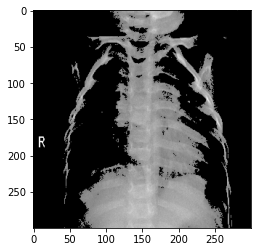

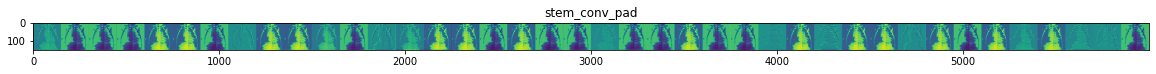

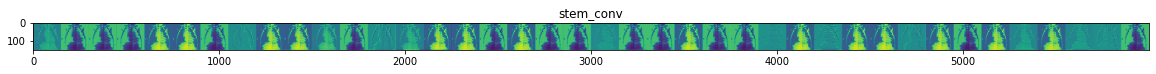

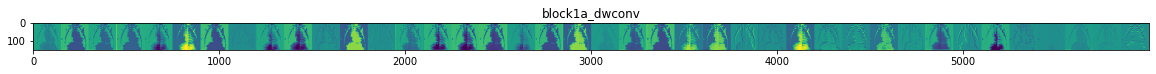

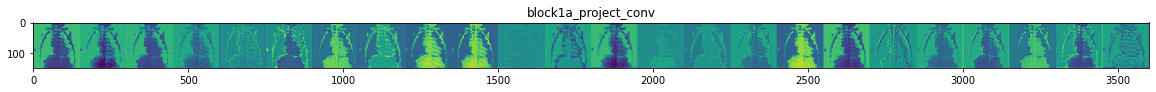

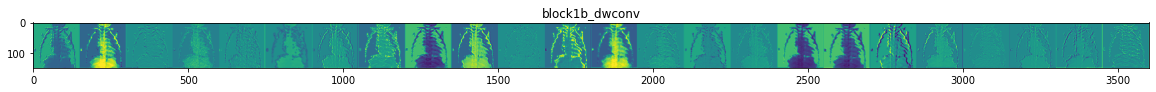

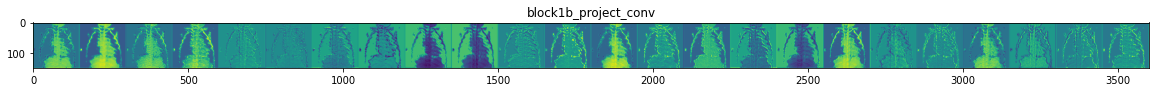

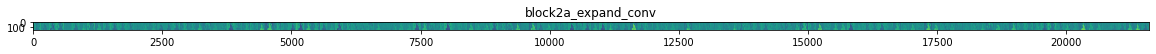

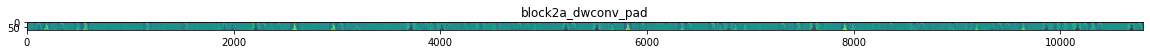

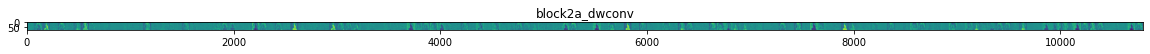

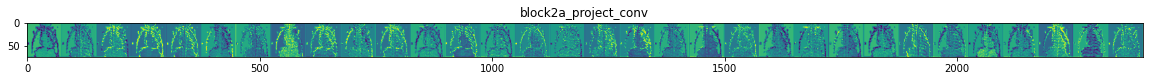

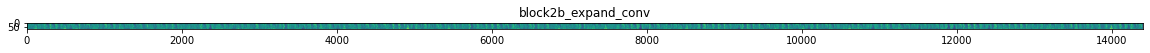

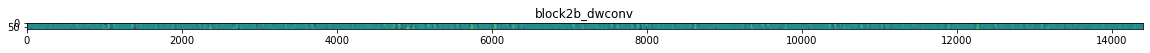

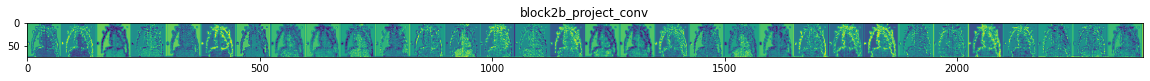

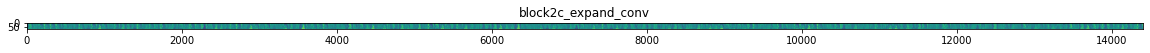

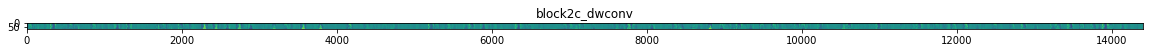

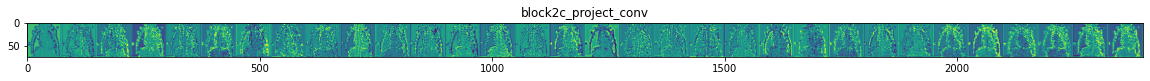

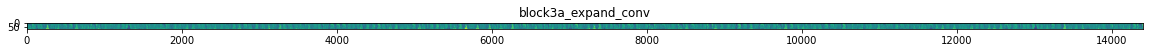

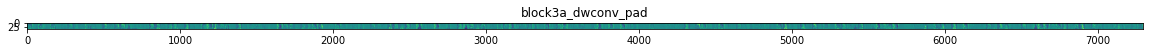

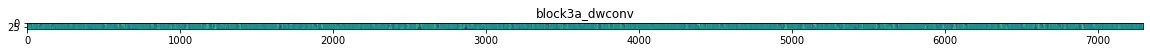

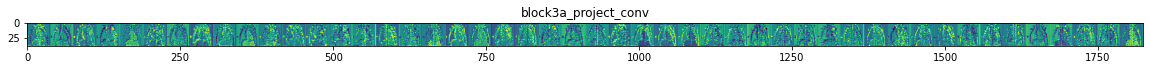

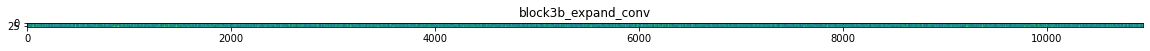

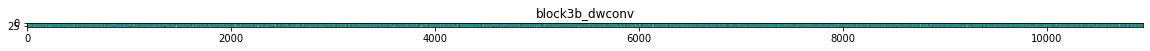

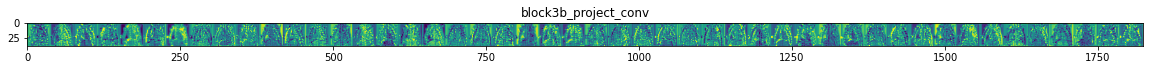

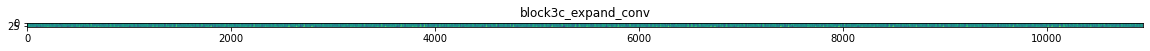

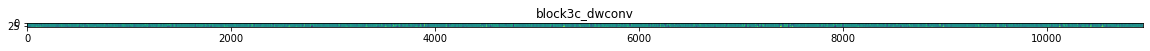

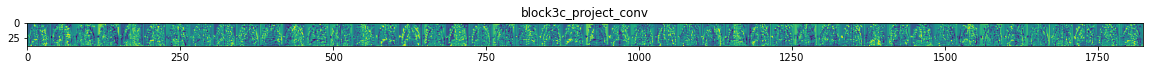

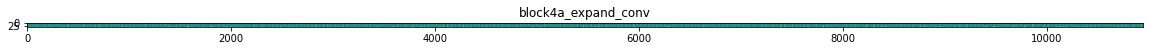

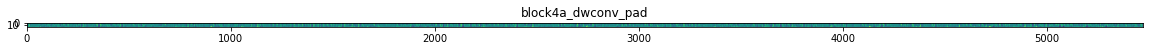

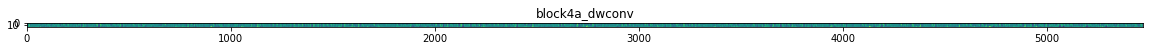

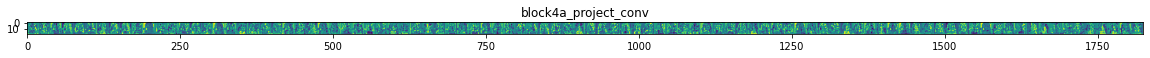

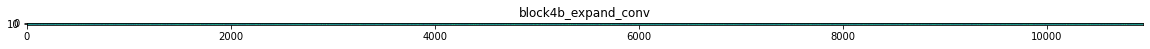

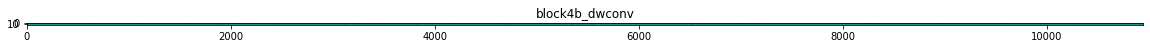

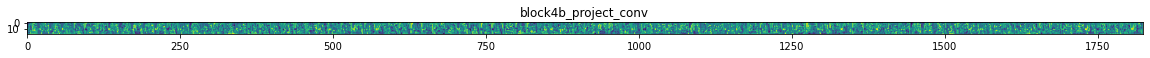

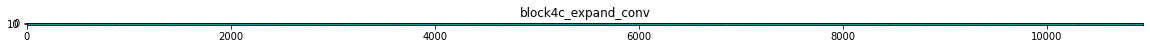

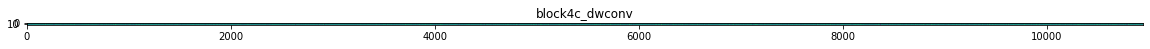

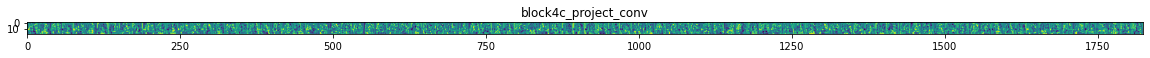

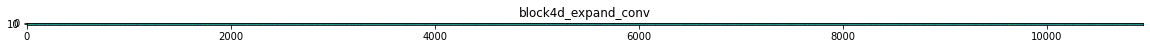

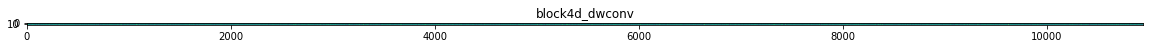

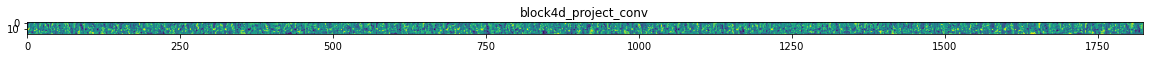

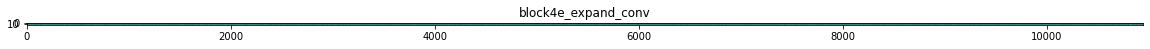

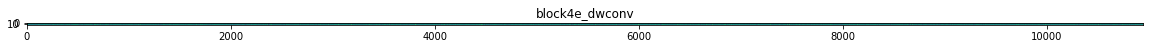

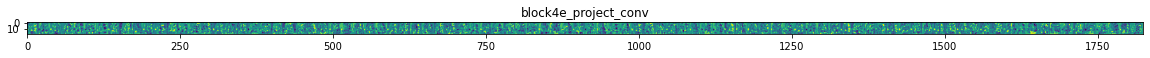

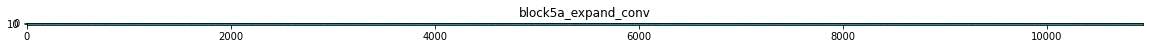

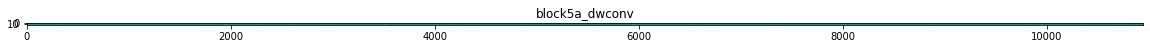

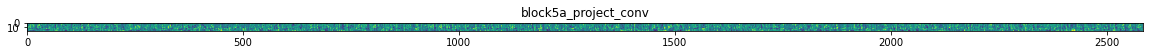

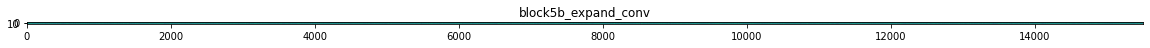

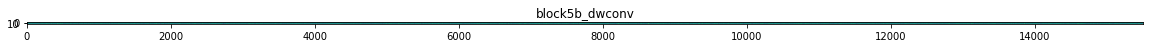

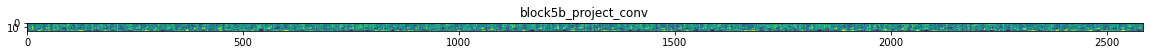

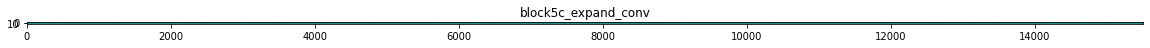

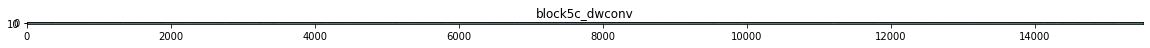

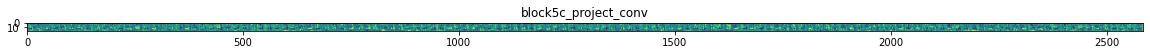

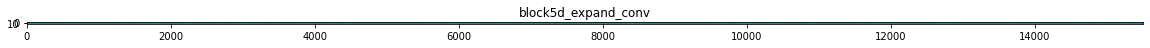

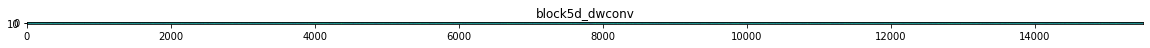

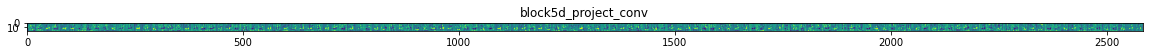

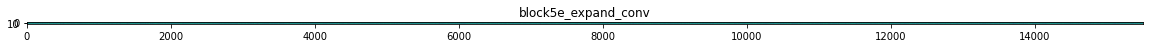

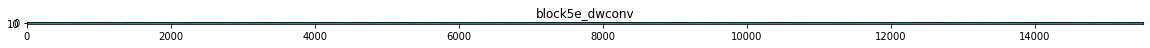

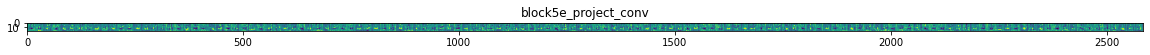

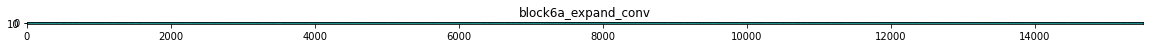

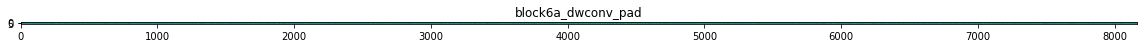

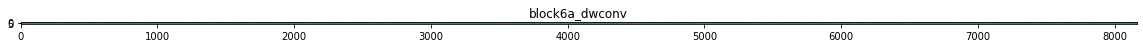

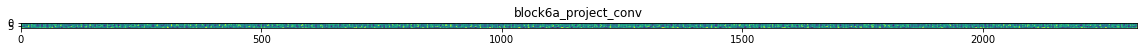

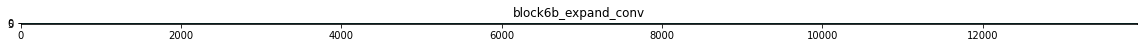

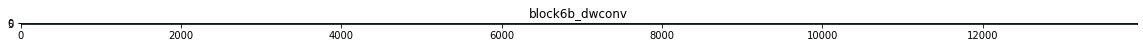

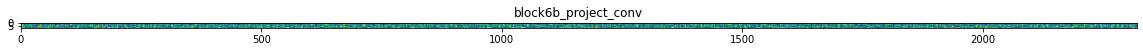

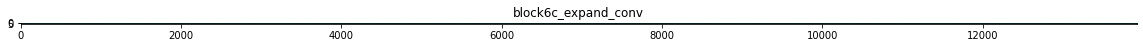

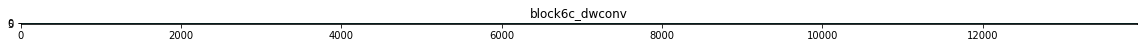

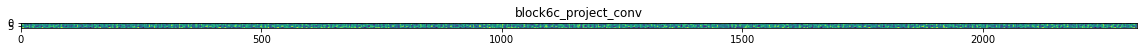

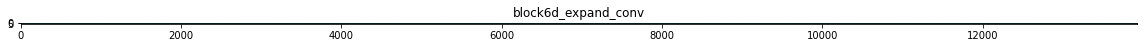

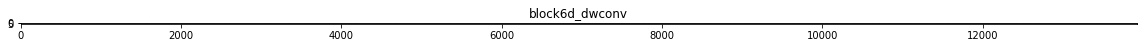

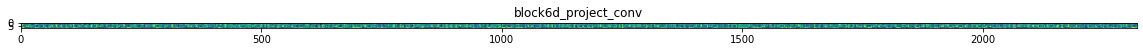

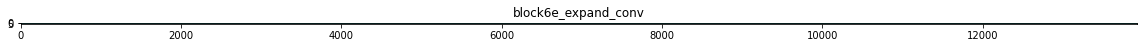

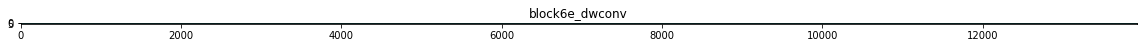

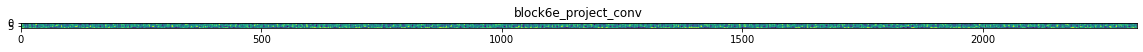

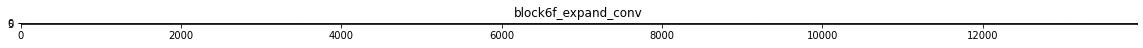

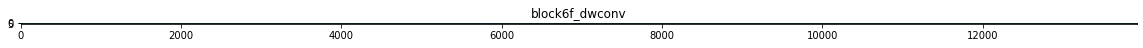

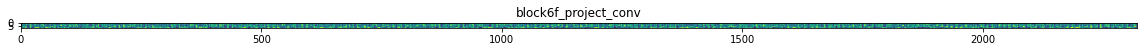

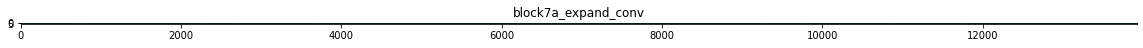

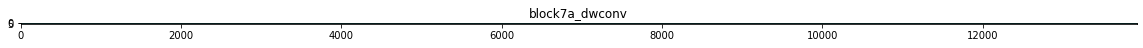

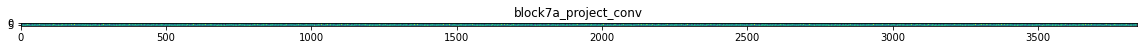

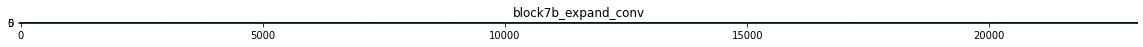

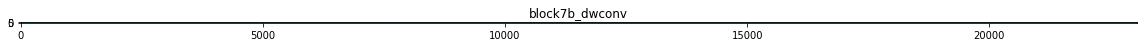

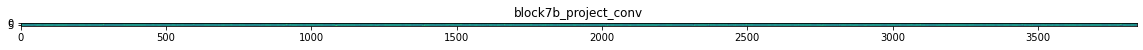

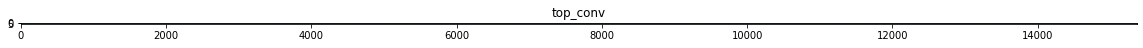

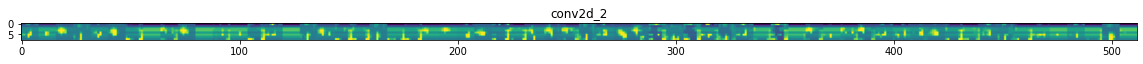

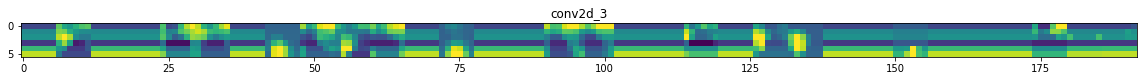

In [28]:
successive_outputs = [layer.output for layer in model.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

image = cv2.imread("/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0128-0001.jpeg")
image = cv2.resize(image,(300,300))
_, thresh = cv2.threshold(image,127,255,cv2.THRESH_TOZERO)
plt.imshow(thresh)
thresh = np.expand_dims(thresh, axis=0)

successive_feature_maps = visualization_model.predict(thresh)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if 'conv' in  layer_name and len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 